# SegNet
#### tensorflow==2.18.0

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model

In [14]:
train_dir = r"C:\Users\91909\Desktop\ML\DATA\PlantVillage-Dataset-master\PlantVillage-Dataset-master\raw\PLANT_VILLAGE_SPLIT\train"
test_dir = r"C:\Users\91909\Desktop\ML\DATA\PlantVillage-Dataset-master\PlantVillage-Dataset-master\raw\PLANT_VILLAGE_SPLIT\test"
val_dir = r"C:\Users\91909\Desktop\ML\DATA\PlantVillage-Dataset-master\PlantVillage-Dataset-master\raw\PLANT_VILLAGE_SPLIT\val"

In [15]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16

In [16]:
def preprocess_function(image):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image

In [17]:
datagen = ImageDataGenerator(rescale=1.0/255,
                             preprocessing_function=preprocess_function)

In [18]:
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 32572 images belonging to 38 classes.
Found 10849 images belonging to 38 classes.
Found 10885 images belonging to 38 classes.


In [19]:
def encoder_block(x, filters):
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    return x

def decoder_block(x, filters):
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

In [20]:
def segnet(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    e1 = encoder_block(inputs, 16)
    e2 = encoder_block(e1, 32)
    e3 = encoder_block(e2, 64)

    b = Conv2D(128, (3, 3), padding='same')(e3)
    b = BatchNormalization()(b)
    b = Activation('relu')(b)

    d3 = decoder_block(b, 64)
    d2 = decoder_block(d3, 32)
    d1 = decoder_block(d2, 16)

    outputs = Conv2D(38, (1, 1), activation='softmax')(d1)  
    outputs = tf.keras.layers.GlobalAveragePooling2D()(outputs)

    model = Model(inputs, outputs)
    return model

input_shape = (224, 224, 3)
num_classes = 38
model = segnet(input_shape, num_classes)

In [21]:
model.compile(tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_14 (Conv2D)          (None, 224, 224, 16)      448       
                                                                 
 batch_normalization_13 (Bat  (None, 224, 224, 16)     64        
 chNormalization)                                                
                                                                 
 activation_13 (Activation)  (None, 224, 224, 16)      0         
                                                                 
 conv2d_15 (Conv2D)          (None, 224, 224, 16)      2320      
                                                                 
 batch_normalization_14 (Bat  (None, 224, 224, 16)     64        
 chNormalization)                                          

In [23]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.005, patience=5, restore_best_weights=True)

In [24]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stopping]
)

Epoch 1/10
2036/2036 [==============================] - 663s 323ms/step - loss: 2.4267 - accuracy: 0.3765 - val_loss: 2.1237 - val_accuracy: 0.4218
Epoch 2/10
2036/2036 [==============================] - 633s 311ms/step - loss: 1.6362 - accuracy: 0.5903 - val_loss: 1.3279 - val_accuracy: 0.6969
Epoch 3/10
2036/2036 [==============================] - 643s 316ms/step - loss: 1.3244 - accuracy: 0.7044 - val_loss: 1.1340 - val_accuracy: 0.7563
Epoch 4/10
2036/2036 [==============================] - 619s 304ms/step - loss: 1.1667 - accuracy: 0.7606 - val_loss: 1.1893 - val_accuracy: 0.7327
Epoch 5/10
2036/2036 [==============================] - 630s 310ms/step - loss: 1.0600 - accuracy: 0.7973 - val_loss: 1.0394 - val_accuracy: 0.7756
Epoch 6/10
2036/2036 [==============================] - 649s 319ms/step - loss: 0.9918 - accuracy: 0.8210 - val_loss: 1.0609 - val_accuracy: 0.7533
Epoch 7/10
2036/2036 [==============================] - 656s 322ms/step - loss: 0.9326 - accuracy: 0.8409 - val_

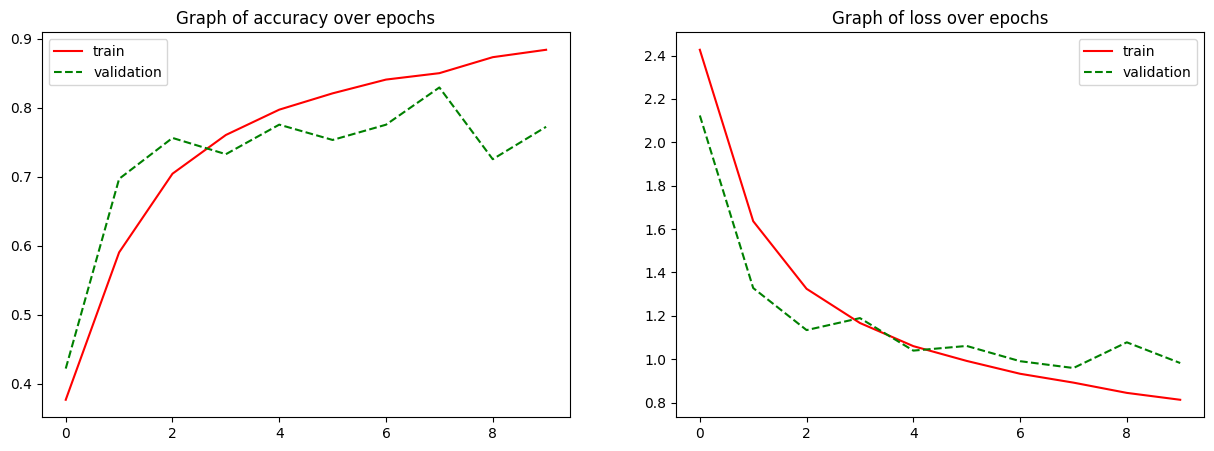

In [25]:
def printplot(history):
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history.history["accuracy"], color="red", label="train")
        plt.plot(history.history["val_accuracy"], color="green", label="validation", linestyle="dashed")
        plt.title("Graph of accuracy over epochs")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history["loss"], color="red", label="train")
        plt.plot(history.history["val_loss"], color="green", label="validation", linestyle="dashed")
        plt.title("Graph of loss over epochs")
        plt.legend()

printplot(history)

In [30]:
model.save('SegNet.h5')

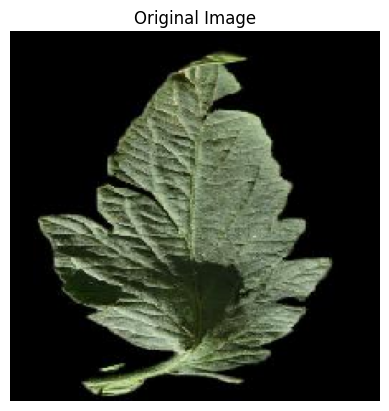

1/1 [==============================] - 1s 688ms/step
Predicted Class: Tomato___healthy
Actual Class: Tomato___healthy


In [27]:
images, labels = next(val_generator)

selected_image = images[0]
selected_label = labels[0]

plt.imshow(selected_image)
plt.title("Original Image")
plt.axis('off')
plt.show()

image_for_prediction = np.expand_dims(selected_image, axis=0)

predicted_probs = model.predict(image_for_prediction)
predicted_class = np.argmax(predicted_probs, axis=1)

actual_class = np.argmax(selected_label)

class_names = list(val_generator.class_indices.keys())

predicted_class_name = class_names[predicted_class[0]]
actual_class_name = class_names[actual_class]

print(f"Predicted Class: {predicted_class_name}")
print(f"Actual Class: {actual_class_name}")

In [28]:
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

681/681 [==============================] - 95s 140ms/step - loss: 0.9990 - accuracy: 0.7660
Test Accuracy: 76.60%
Test Loss: 0.9990


1/1 [==============================] - 0s 39ms/step


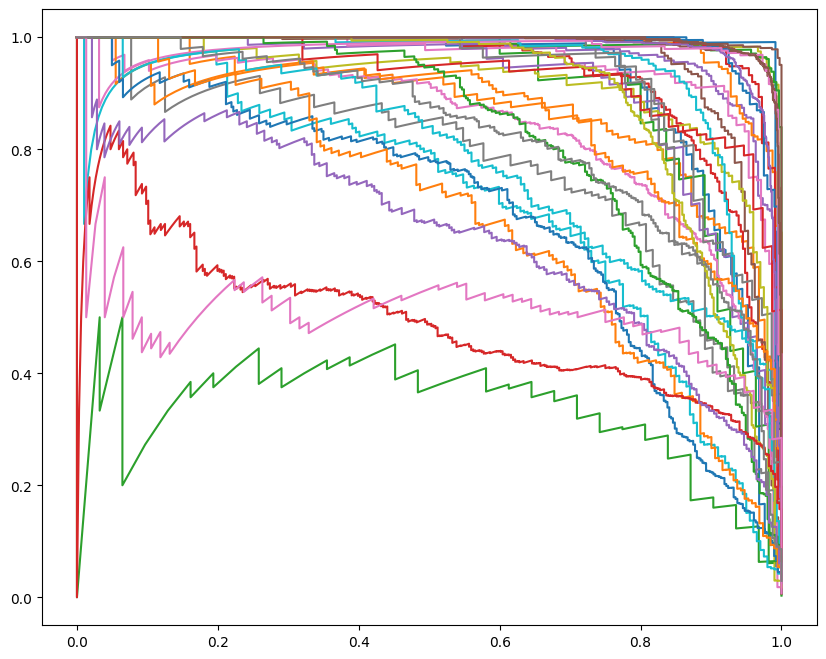

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
from tensorflow.keras.models import load_model

y_true = []
y_scores = []

for i in range(len(test_generator)):
    images, labels = test_generator[i]
    preds = model.predict(images)

    y_true.append(labels)
    y_scores.append(preds)

y_true = np.vstack(y_true)
y_scores = np.vstack(y_scores)

plt.figure(figsize=(10, 8))
average_precision = []

for class_idx in range(38):
    precision, recall, _ = precision_recall_curve(y_true[:, class_idx], y_scores[:, class_idx])
    ap = average_precision_score(y_true[:, class_idx], y_scores[:, class_idx])
    average_precision.append(ap)
    plt.plot(recall, precision)